## Problem statement

University admissions can be confusing and stressful. Most of the times, in order to know the status of admission it can take up a lot of time.

In this kernel, we will try to explore how we can maximize the Chance of Admit by focussing only on the most prominent factors.

## Importing necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy.stats as stats
import warnings

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
warnings.filterwarnings('ignore')

/kaggle/input/graduate-admissions/Admission_Predict.csv
/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv


## Reading and understanding data

Let's choose the dataset Version1.1 with more number of columns

In [2]:
df = pd.read_csv('/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
df.sample(5)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
359,360,321,107,2,2.0,1.5,8.44,0,0.81
13,14,307,109,3,4.0,3.0,8.00,1,0.62
283,284,321,111,3,2.5,3.0,8.90,1,0.80
343,344,305,103,2,2.5,3.5,8.13,0,0.59
21,22,325,114,4,3.0,2.0,8.40,0,0.70


In [4]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

Dropping the column `Serial No.`, as it won't be necessary for analyzing the chance of admit.

In [5]:
serial_nums = df['Serial No.']
df.drop(columns=['Serial No.'],inplace=True)

In [6]:
df.shape

(500, 8)

In the columns `Chance of admit` and `LOR`, there are extra spaces in the end, so we will remove that from the columns name.

In [7]:
df.rename(columns={"Chance of Admit ":"Chance of Admit",
                  "LOR ":"LOR"},inplace=True)

In [8]:
df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


Separating numerical and categorical columns for analysis.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [10]:
df.nunique().sort_values()

Research               2
University Rating      5
SOP                    9
LOR                    9
TOEFL Score           29
GRE Score             49
Chance of Admit       61
CGPA                 184
dtype: int64

Even though few columns are integer or float types but they seem to have discrete unique values and hence they are most probably categorical in nature.

In [11]:
cat_columns = ['University Rating','SOP','LOR','Research']

In [12]:
num_columns = list(set(df.columns) - set(cat_columns))
num_columns 

['Chance of Admit', 'GRE Score', 'TOEFL Score', 'CGPA']

**Check for nulls**

In [13]:
df.isna().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

There are no null values in the dataset so we can skip that (treating null values) part. However, we will still have to check for outliers in the dataset (exclusing the dependant variable).

## Observing the Dependant variable

### Chance of Admit

In [14]:
df['Chance of Admit'].head()

0    0.92
1    0.76
2    0.72
3    0.80
4    0.65
Name: Chance of Admit, dtype: float64

In [15]:
df['Chance of Admit'].describe()

count    500.00000
mean       0.72174
std        0.14114
min        0.34000
25%        0.63000
50%        0.72000
75%        0.82000
max        0.97000
Name: Chance of Admit, dtype: float64

Creating a new columns high chance to identify profiles who are most likely to get an admit.

In [16]:
q3 = df['Chance of Admit'].quantile(q=0.75)
df['High Chance'] = df['Chance of Admit'].apply(lambda x: 1 if x>= q3 else 0)

Chance of Admit is a `continuious numerical` variable so we can use box plot, violin plot,histogram or density plot. 

Let's observe a density plot below.

Skew range, current: -0.289966210041158
Skew range, log: -0.8153821572544562
Kurtosis, current: -0.4546817998465431
Kurtosis range, log: 0.5438283413897618


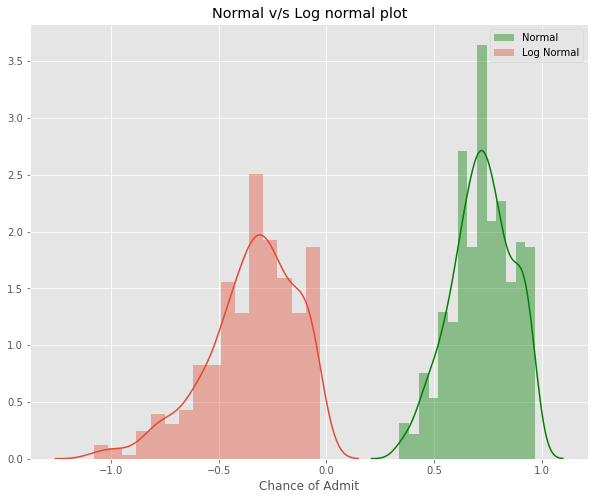

In [17]:
y = df['Chance of Admit']
y_skew = y.skew()
ylog_skew = np.log(y).skew()
y_kurt = y.kurtosis()
ylog_kurt = np.log(y).kurtosis()
print('Skew range, current:',y_skew)
print('Skew range, log:',ylog_skew)
print('Kurtosis, current:',y_kurt)
print('Kurtosis range, log:',ylog_kurt)

plt.figure(figsize=(10,8));
plt.title('Normal v/s Log normal plot')
sns.distplot(y,color='g',label="Normal")
sns.distplot(np.log(y),label="Log Normal")
plt.legend()
plt.show()

Since the skew and kurtosis values are not improving with transformation, skipping the transformation as such.

## Observing the independant variables

### Univariate analysis

#### Categorical columns

In [18]:
cat_columns

['University Rating', 'SOP', 'LOR', 'Research']

Checking and removing outliers in the categorical data.

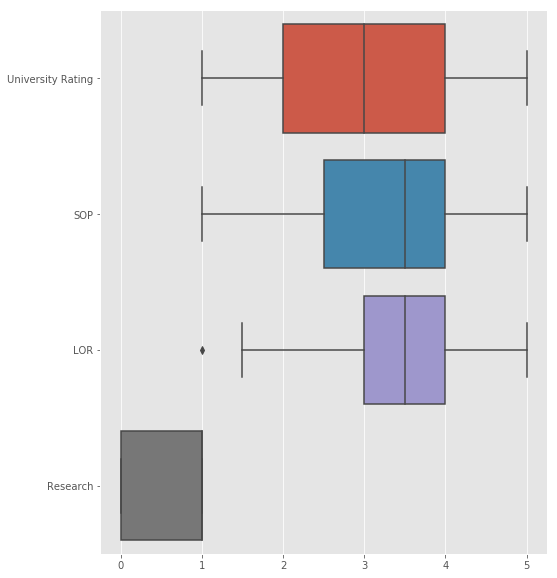

In [19]:
n_cat_cols = len(cat_columns)
# fig,ax = plt.subplots(1,n_cat_cols,figsize=(8*n_cat_cols,6))
# for i,col_name in enumerate(cat_columns):
#     plt.subplot(ax[i])
plt.rcParams['figure.figsize'] = 8,10
sns.boxplot(data=df.loc[:,cat_columns],orient='h')
plt.show()   

An outlier was spotted only in the LOR column (in the left side of plot), we will treat that using **IQR method**.

In [20]:
df.iloc[347]

GRE Score            299.00
TOEFL Score           94.00
University Rating      1.00
SOP                    1.00
LOR                    1.00
CGPA                   7.34
Research               0.00
Chance of Admit        0.42
High Chance            0.00
Name: 347, dtype: float64

In [21]:
q1 = df['LOR'].quantile(q=0.25)
q3 = df['LOR'].quantile(q=0.75)

lower_limit = q1 - (q3-q1)*1.5
df['LOR'].loc[df['LOR'] < lower_limit] = np.NaN

# I checked the forward value and it is 2, so it will be safe to replace with forward fill
df['LOR'].fillna(method="ffill",inplace=True)

To get an idea of data distribution, lets check categorical columns. 

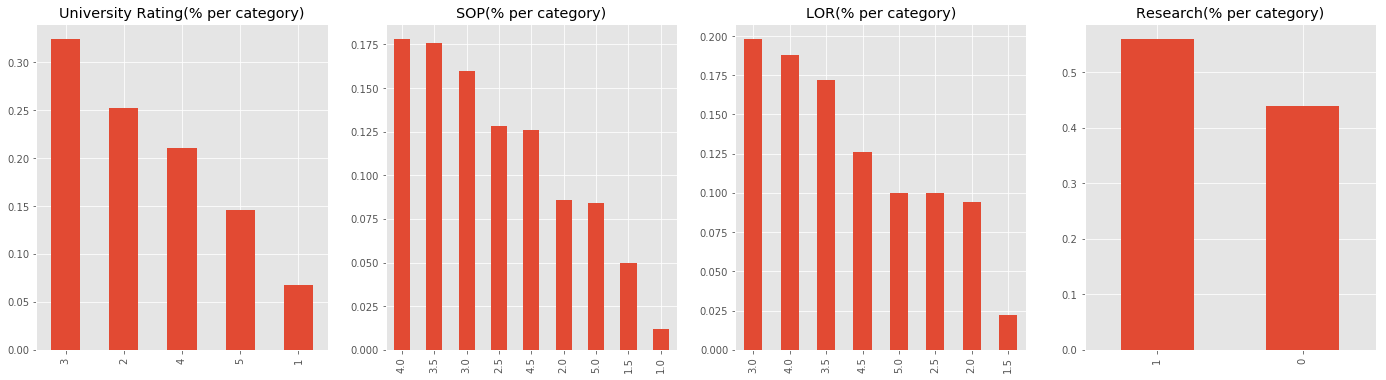

In [22]:
fig,ax = plt.subplots(1,n_cat_cols,figsize=(6*n_cat_cols,6))

for i,col_name in enumerate(cat_columns):
    plt.subplot(ax[i])
    df[col_name].value_counts(normalize=True).plot.bar(title=col_name+"(% per category)")
plt.show()

#### Numeric columns

In [23]:
num_columns

['Chance of Admit', 'GRE Score', 'TOEFL Score', 'CGPA']

In [24]:
# Since Chance of Admit is our target/dependant varaiable, removing it from the num_columns
num_columns.remove('Chance of Admit')
num_columns

['GRE Score', 'TOEFL Score', 'CGPA']

*Check numerical columns for outliers*

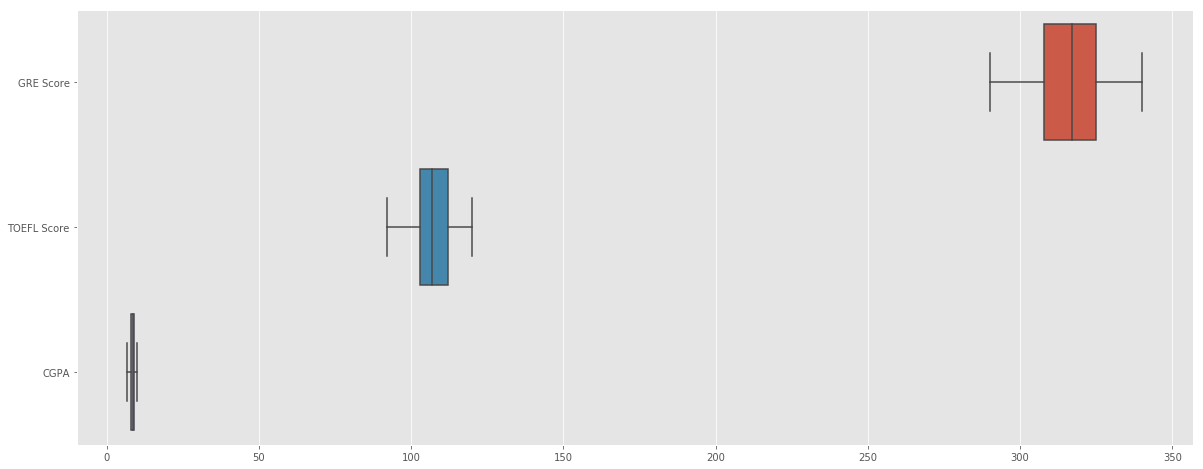

In [25]:
# n_num = len(num_columns)
# fig,ax = plt.subplots(1,n_num,figsize=(6*n_num,6))
# for j,col_name in enumerate(num_columns):
#     plt.subplot(ax[j])
#     sns.distplot(df[col_name],bins=50)
#     plt.subplot(ax[i,j])
plt.rcParams['figure.figsize'] = 20,8
sns.boxplot(data=df.loc[:,num_columns],orient='h')
plt.show()

Since the numerical columns are not having any outliers we can directly move on to the analysis.

We use **z-score method** to spot outliers in the numerical distributions.

#### GRE Score

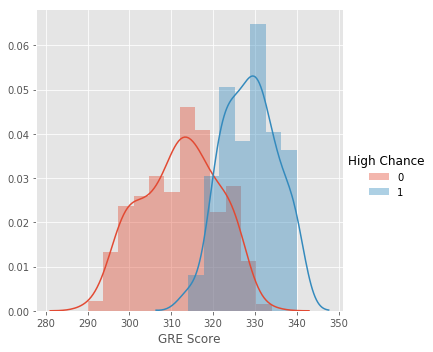

In [26]:
sns.FacetGrid(df,hue='High Chance',height=5)\
    .map(sns.distplot,'GRE Score')\
    .add_legend()
plt.show()

#### TOEFL Score

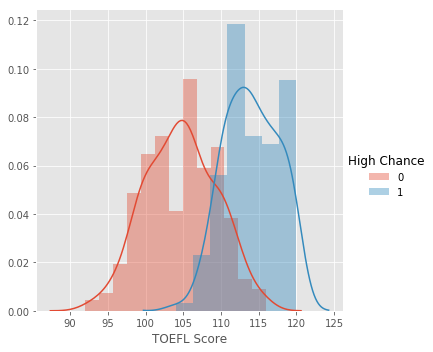

In [27]:
sns.FacetGrid(df,hue='High Chance',height=5)\
    .map(sns.distplot,'TOEFL Score')\
    .add_legend()
plt.show()

#### CGPA

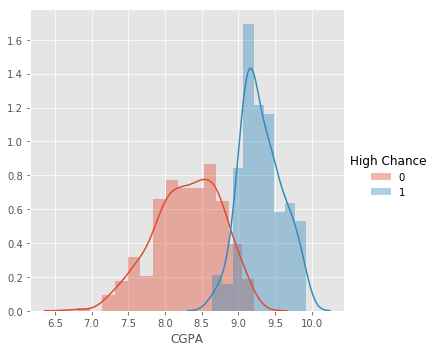

In [28]:
sns.FacetGrid(df,hue='High Chance',height=5)\
    .map(sns.distplot,'CGPA')\
    .add_legend()
plt.show()

The higher the PDF(probability distribution function) of two classes be separated from each other the more likely the feature will help in predicting the output (Chance of Admit).

And from the above diagrams, it can be seen that CGPA has the most separation. Which implies CGPA will be the most prominent factor determining a high chance of admit.

### Bivariate analysis

In [29]:
n_cat_cols,cat_columns

(4, ['University Rating', 'SOP', 'LOR', 'Research'])

#### Categorical v/s Conitnuous

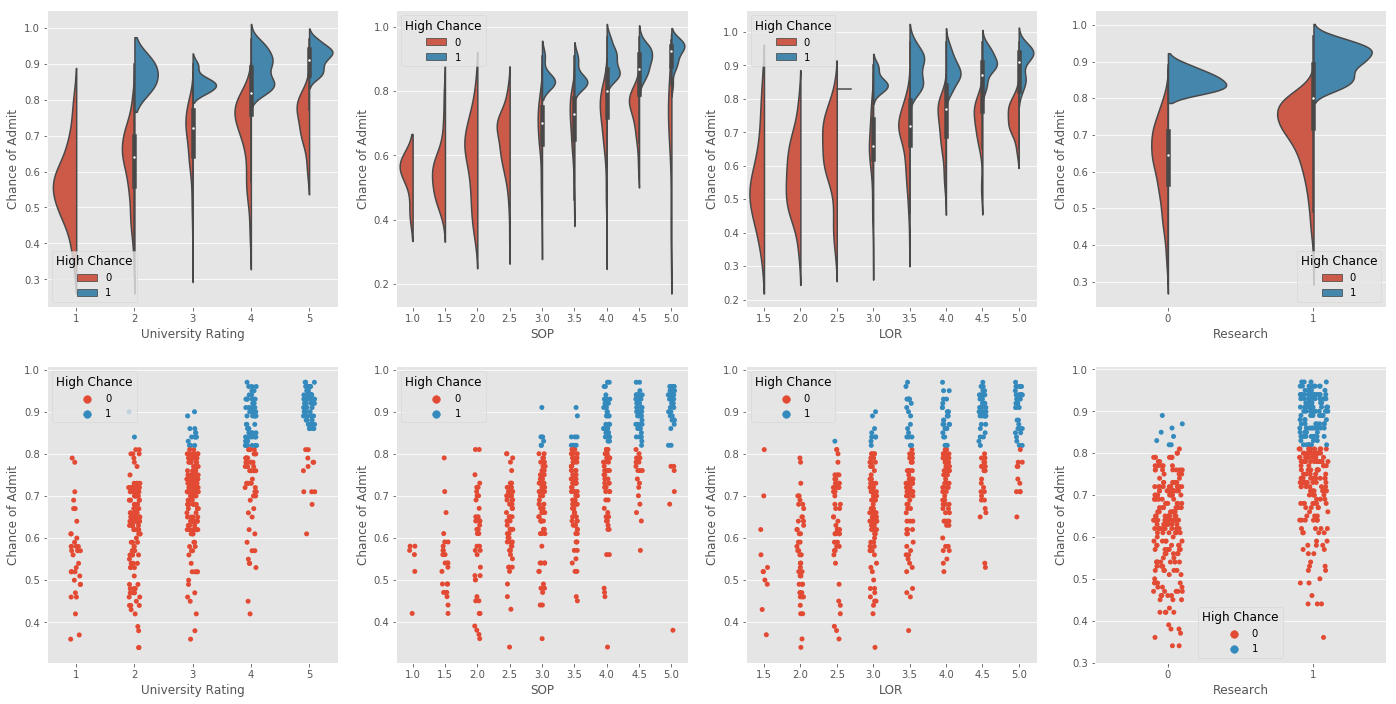

In [30]:
fig,ax = plt.subplots(2,n_cat_cols,figsize=(6*n_cat_cols,12))
for i,col_name in enumerate(cat_columns):
    plt.subplot(ax[0,i])
    sns.violinplot(data=df,x=col_name,y='Chance of Admit',hue="High Chance",split=True)
    plt.subplot(ax[1,i])
#     sns.countplot(data=df,y=col_name,hue="High Chance")
    sns.stripplot(data=df,x=col_name,y='Chance of Admit',hue="High Chance",jitter=True)

plt.show()

The following insights can be extracted from the above charts:
- **University Rating**: It shows that if a student's University rating is good, the chance of admit increases. A student who studied in a university with rating 4 or 5 has a higher chance.
- **SOP**: An SOP score more than 4 will be favourable.
- **LOR**: Higher chance is seen for candidates with score more than 4.5.
- **Research**: Many students who had high acceptance chance had a history of publishing paper. However, there are many students who published paper yet having low chance.

### Does having a good GRE score or TOEFL score or CGPA aids in higher chance of Admit?

Continuous v/s continuous variables

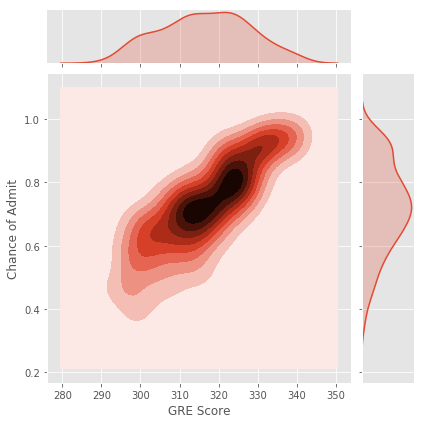

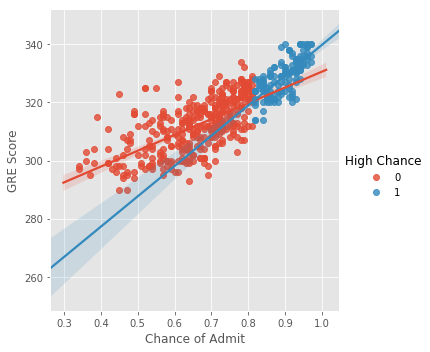

In [31]:
sns.jointplot(data=df,x="GRE Score",y='Chance of Admit',kind="kde")
sns.lmplot(data=df,y="GRE Score",x='Chance of Admit',hue="High Chance")
plt.show()

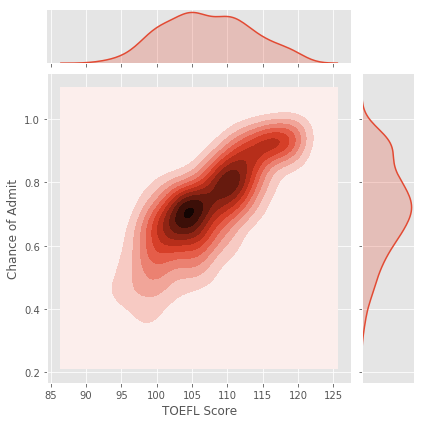

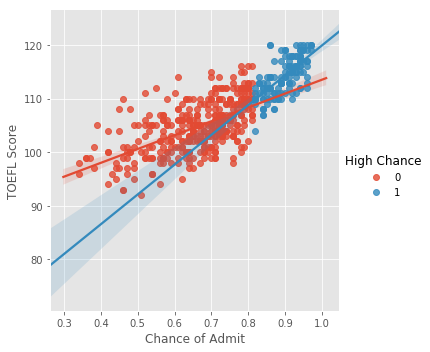

In [32]:
sns.jointplot(data=df,x="TOEFL Score",y='Chance of Admit',kind="kde")
sns.lmplot(data=df,x='Chance of Admit',y="TOEFL Score",hue="High Chance")
plt.show()

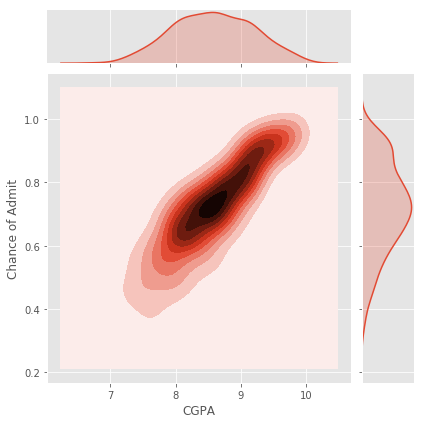

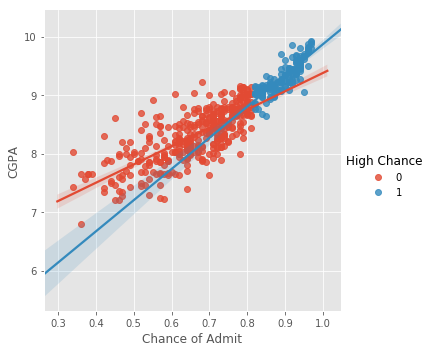

In [33]:
sns.jointplot(data=df,x="CGPA",y='Chance of Admit',kind="kde")
sns.lmplot(data=df,x='Chance of Admit',y="CGPA",hue="High Chance")
plt.show()

Probably the answer for the above questionm is Yes!

All the 3 three features have a strong linear relationship with the `Chance of Admit`.

Now let us compare the relationship between 
- GRE Score and TOEFL Score
- GRE Score and CGPA
- CGPA and TOEFL Score

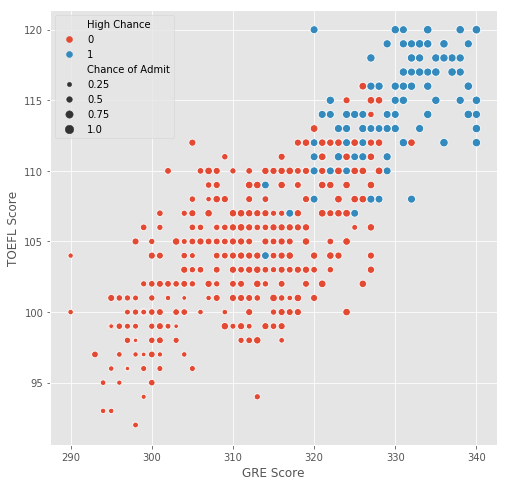

In [34]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df,x="GRE Score",y='TOEFL Score',size="Chance of Admit",hue="High Chance")

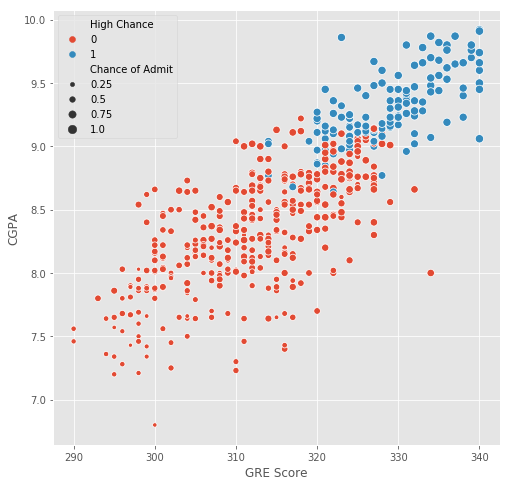

In [35]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df,x="GRE Score",y='CGPA',size="Chance of Admit",hue="High Chance")

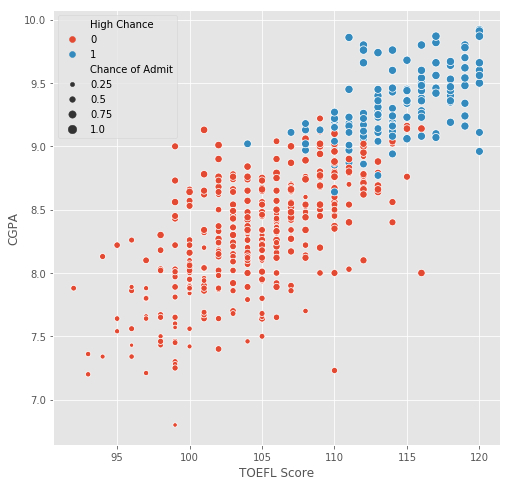

In [36]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df,x="TOEFL Score",y='CGPA',size="Chance of Admit",hue="High Chance")

### Categorical v/s Categorical

In [37]:
cat_columns

['University Rating', 'SOP', 'LOR', 'Research']

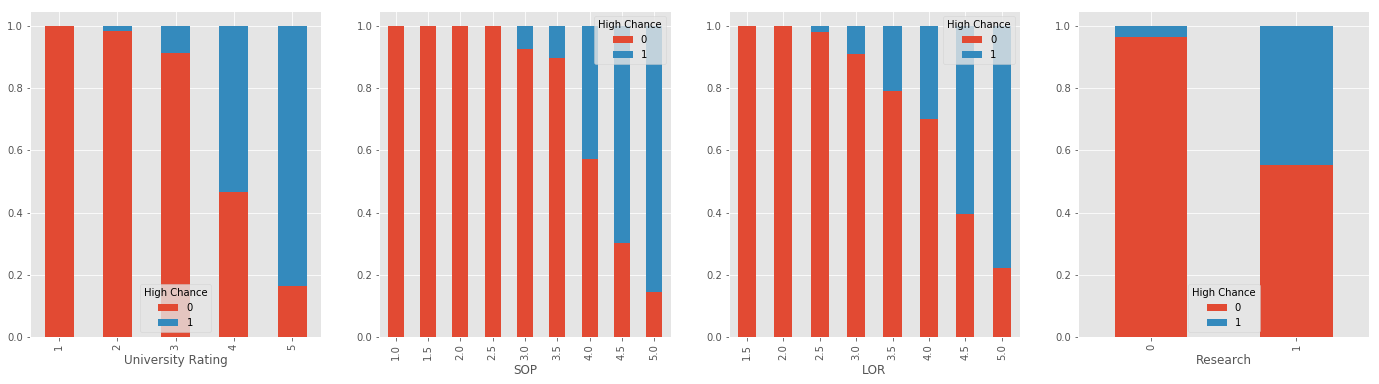

In [38]:
fig,ax = plt.subplots(1,n_cat_cols,figsize=(6*n_cat_cols,6))
for i,col in enumerate(cat_columns):
    # Create a cross table for stacked graph
    pd.crosstab(df[col],df['High Chance'])

    ct = pd.crosstab(df[col],df['High Chance'],normalize="index")
    ct.plot.bar(stacked=True,ax=ax[i])
plt.show()

### Correlation between columns

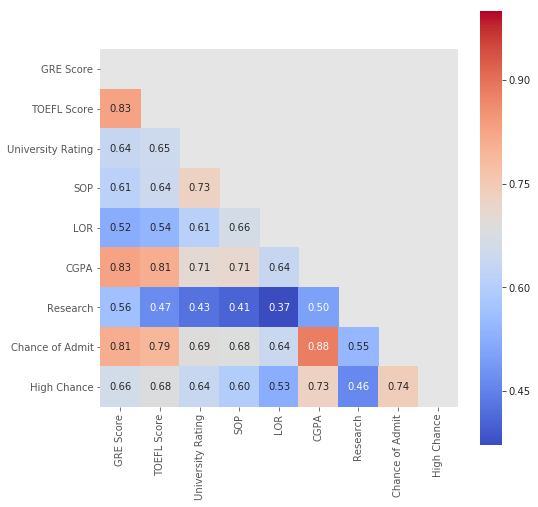

In [39]:
# Removing serial no. and checking correlation.
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig,ax = plt.subplots(figsize=(8, 8))
with sns.axes_style("white"):
#     cmap="YlGnBu"
    sns.heatmap(corr, ax=ax, annot=True, mask=mask, square=True,fmt= '.2f',cmap="coolwarm")
plt.show()

From the map, we can see that the target `Chance of Admit` has the most linear relation with the following :
<br/>

Columns | Corelation 
---|---
CGPA | 0.88
GRE Score | 0.81
TOEFL | 0.79

<br/>
The least correlated featues is `Research` .

### Pair Plot

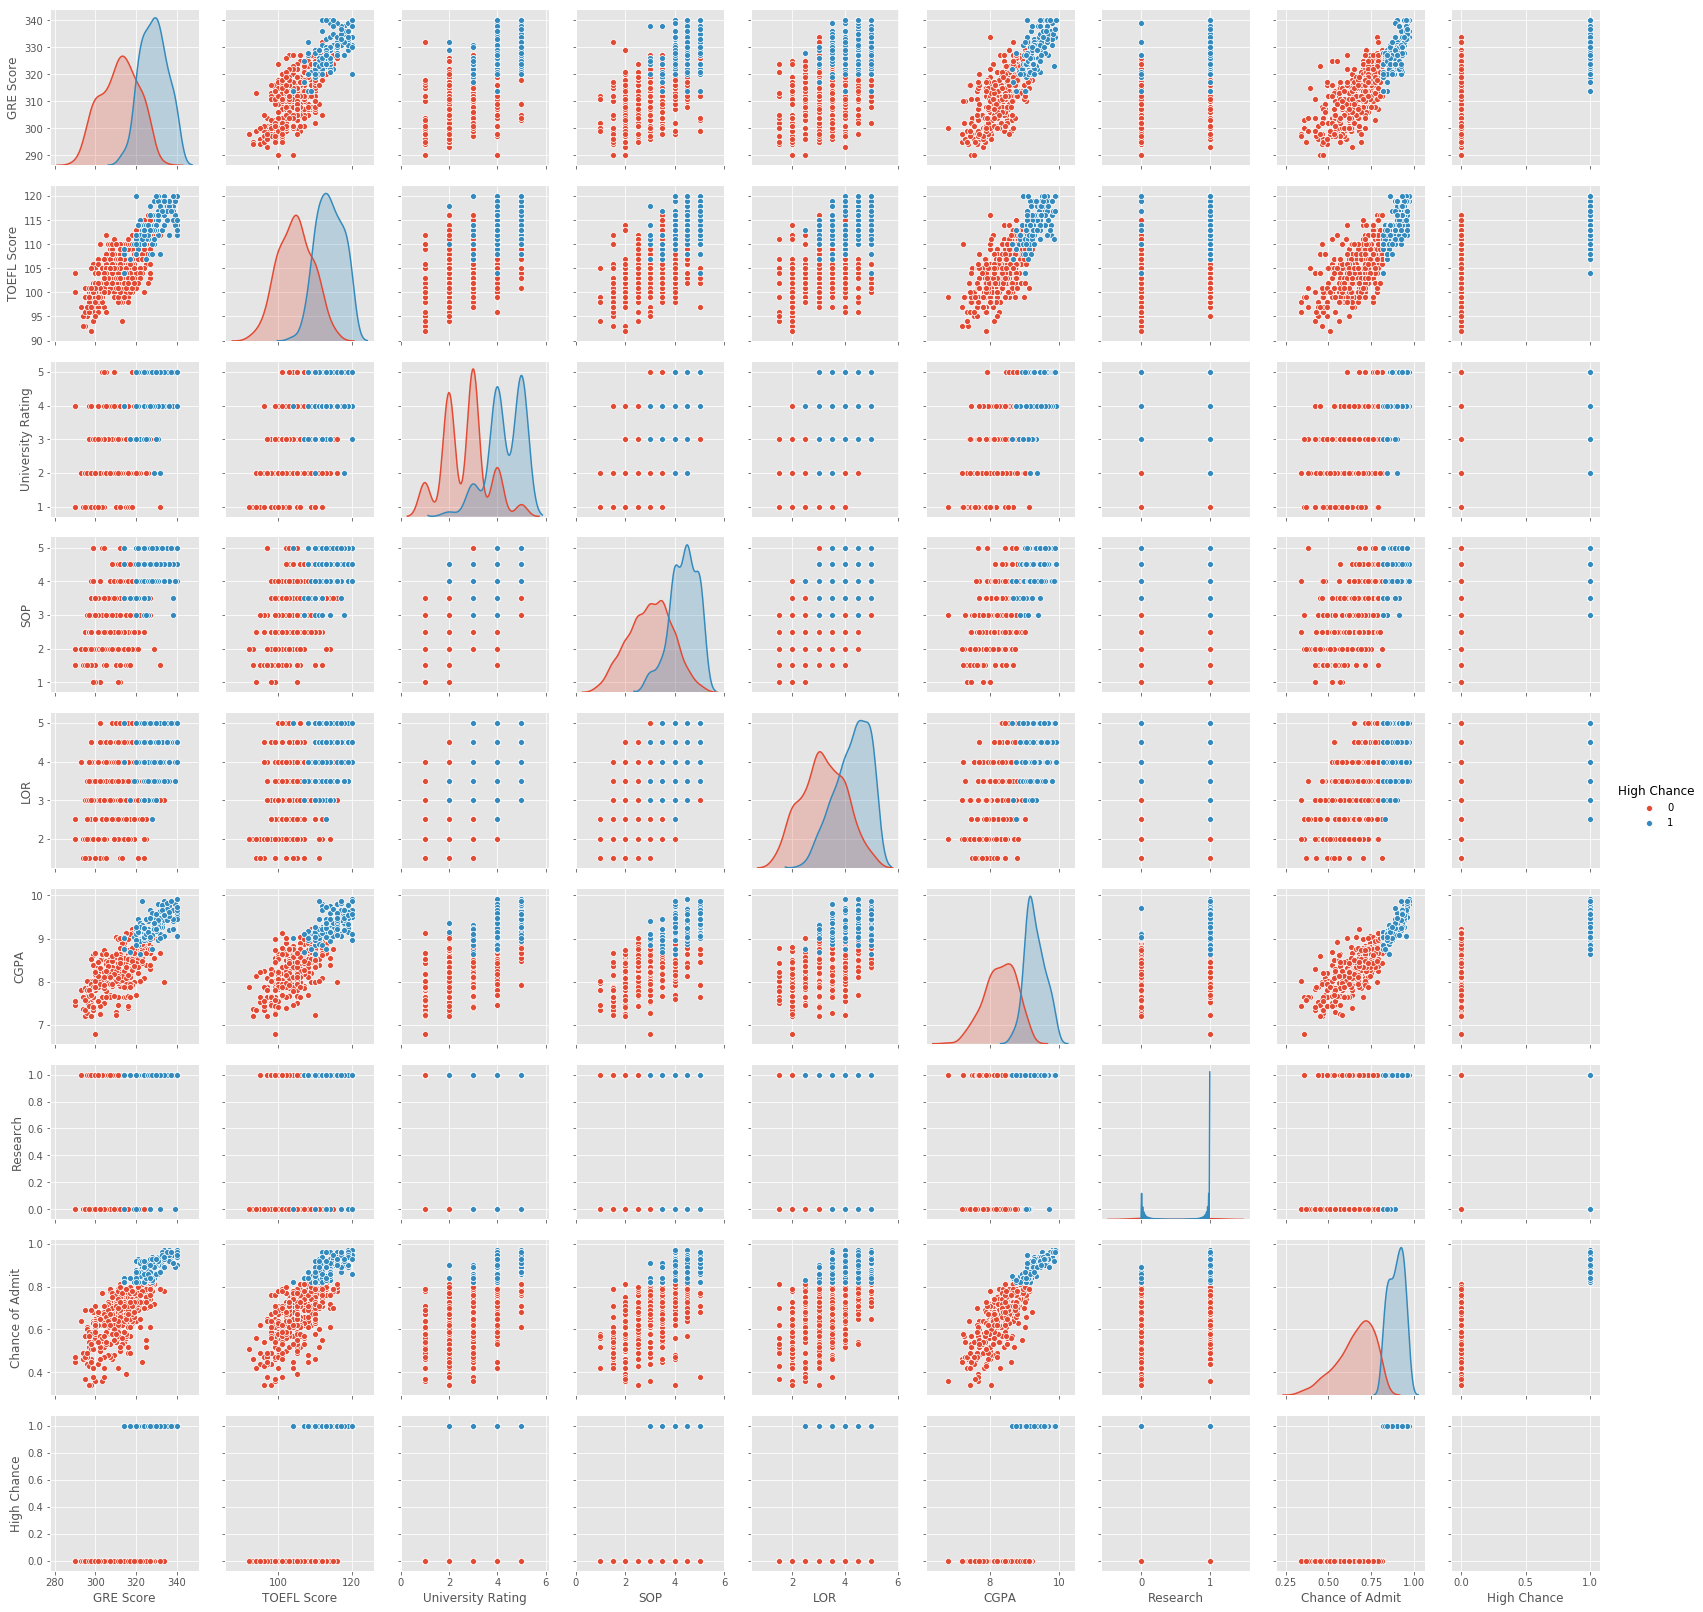

In [40]:
ax = sns.pairplot(df,hue="High Chance")

### Conclusion

> Focusing on LESS to get MORE

If a student wants to secure higher `Chance of Admit` with minimal amount of effort then the person should be focussing more on maximizing their CGPA, GRE Score and TOEFL Score.